In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import os
from datetime import datetime, timedelta

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, adjusted_rand_score

# Stats
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Survival Analysis
try:
    from lifelines import KaplanMeierFitter
    from lifelines import BetaGeoFitter, GammaGammaFitter
    LIFELINES_AVAILABLE = True
except ImportError:
    LIFELINES_AVAILABLE = False
    print("Install lifelines: pip install lifelines")


Install lifelines: pip install lifelines


In [4]:
# Market Basket
try:
    from mlxtend.frequent_patterns import apriori, association_rules
    from mlxtend.preprocessing import TransactionEncoder
    MLXTEND_AVAILABLE = True
except ImportError:
    MLXTEND_AVAILABLE = False
    print("Install mlxtend: pip install mlxtend")

Install mlxtend: pip install mlxtend


In [5]:
# UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("Install umap: pip install umap-learn")

import time

In [6]:
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Loading both the sheets of the UCI Online Retail II dataset, Sheet 1 = Year 2009-2010, Sheet 2 = Year 2010-2011
try:
    df_1 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
    df_2 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
    df = pd.concat([df_1, df_2], ignore_index=True)
    print(f"Combined dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
except:
    # If only one sheet available
    df = pd.read_excel('online_retail_II.xlsx')
    print(f"Single sheet loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

LOADING DATA
Combined dataset: 1,067,371 rows, 8 columns


In [7]:
# Standardize column names
df.columns = df.columns.str.strip()
print(df.head())
print(df.dtypes)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95     13085.00  United Kingdom  
1 2009-12-01 07:45:00   6.75     13085.00  United Kingdom  
2 2009-12-01 07:45:00   6.75     13085.00  United Kingdom  
3 2009-12-01 07:45:00   2.10     13085.00  United Kingdom  
4 2009-12-01 07:45:00   1.25     13085.00  United Kingdom  
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country  


SECTION 2: COMPREHENSIVE DATA QUALITY AUDIT

Data Quality Audit Report:
                 Row_Type  Row_Count  Total_Revenue  Avg_Price  Avg_Qty  Row_Pct  Revenue_Pct
             Cancellation      19494    -1526667.86      44.87   -25.19     1.83        -7.92
  Free_Sample_Promotional       2745           0.00       0.00    91.90     0.26         0.00
Negative_Price_Adjustment          5     -158676.14  -31735.23     1.00     0.00        -0.82
    Return_Without_C_Flag       3457           0.00       0.00  -165.78     0.32         0.00
           Valid_Purchase    1041670    20972594.57       4.08    10.96    97.59       108.74


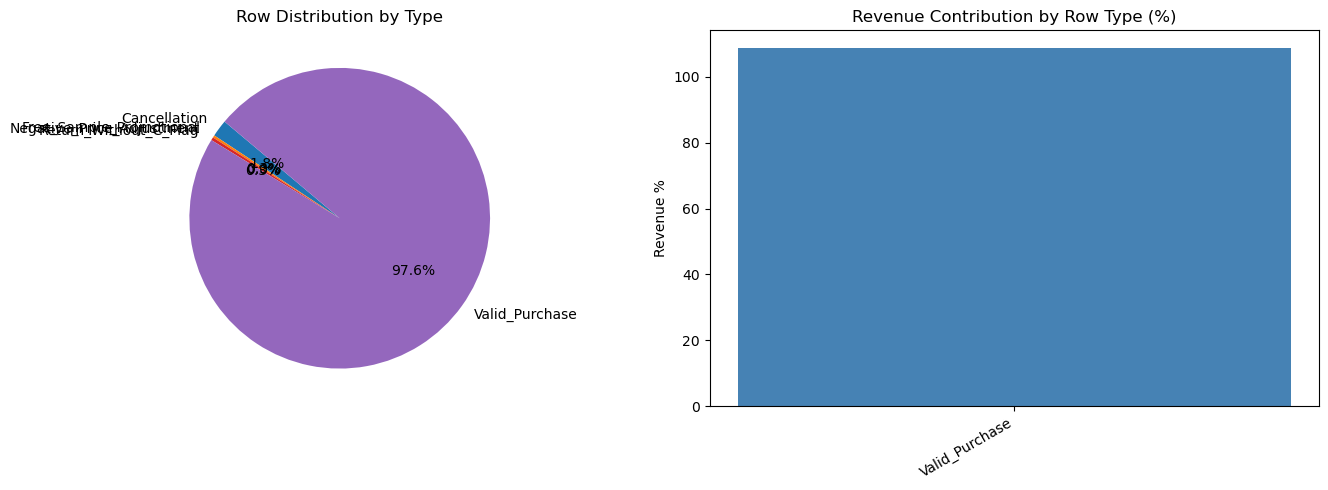

In [8]:

# ─────────────────────────────────────────────────────────────
# SECTION 2: DATA QUALITY AUDIT (QUESTION 2)
# Categorize every row into 5 states
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 2: COMPREHENSIVE DATA QUALITY AUDIT")
print("=" * 60)

def classify_row(row):
    """Classify each transaction into one of 5 states."""
    invoice = str(row.get('Invoice', ''))
    qty     = row.get('Quantity', 0)
    price   = row.get('Price', 0)

    if invoice.startswith('C'):
        return 'Cancellation'
    elif price < 0:
        return 'Negative_Price_Adjustment'
    elif price == 0 and qty > 0:
        return 'Free_Sample_Promotional'
    elif qty < 0 and not invoice.startswith('C'):
        return 'Return_Without_C_Flag'
    else:
        return 'Valid_Purchase'

df['Row_Type'] = df.apply(classify_row, axis=1)

# Revenue impact per category
df['Revenue'] = df['Quantity'] * df['Price']
audit = df.groupby('Row_Type').agg(
    Row_Count=('Invoice', 'count'),
    Total_Revenue=('Revenue', 'sum'),
    Avg_Price=('Price', 'mean'),
    Avg_Qty=('Quantity', 'mean')
).reset_index()
audit['Row_Pct']     = (audit['Row_Count']   / len(df) * 100).round(2)
audit['Revenue_Pct'] = (audit['Total_Revenue'] / df['Revenue'].sum() * 100).round(2)

print("\nData Quality Audit Report:")
print(audit.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].pie(audit['Row_Count'], labels=audit['Row_Type'],
            autopct='%1.1f%%', startangle=140)
axes[0].set_title('Row Distribution by Type')
audit_pos = audit[audit['Total_Revenue'] > 0]
axes[1].bar(audit_pos['Row_Type'], audit_pos['Revenue_Pct'], color='steelblue')
axes[1].set_title('Revenue Contribution by Row Type (%)')
axes[1].set_ylabel('Revenue %')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


In [9]:
# ─────────────────────────────────────────────────────────────
# SECTION 3: MISSING CUSTOMER ID PATTERN ANALYSIS (QUESTION 3)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 3: MISSING CUSTOMER ID PATTERN ANALYSIS")
print("=" * 60)

df['Has_CustomerID'] = df['Customer ID'].notna()

# Compare purchasing patterns
missing_analysis = df.groupby('Has_CustomerID').agg(
    Count=('Invoice', 'count'),
    Avg_Order_Value=('Revenue', 'mean'),
    Avg_Qty=('Quantity', 'mean'),
    Unique_Countries=('Country', 'nunique'),
    Avg_Hour=('InvoiceDate', lambda x: pd.to_datetime(x).dt.hour.mean())
).reset_index()
missing_analysis['Has_CustomerID'] = missing_analysis['Has_CustomerID'].map(
    {True: 'Has_ID', False: 'Missing_ID'}
)
print("\nPurchase Pattern Comparison (Missing vs Present Customer ID):")
print(missing_analysis.to_string(index=False))

# Country distribution for missing IDs
missing_country = df[~df['Has_CustomerID']]['Country'].value_counts().head(10)
print("\nTop 10 Countries with Missing Customer IDs:")
print(missing_country)

# Decision: Drop missing Customer IDs (they cannot be used for RFM)
df_clean = df[
    (df['Has_CustomerID']) &
    (df['Row_Type'] == 'Valid_Purchase') &
    (df['Quantity'] > 0) &
    (df['Price'] > 0)
].copy()
print(f"\nClean dataset after filtering: {df_clean.shape[0]:,} rows")



SECTION 3: MISSING CUSTOMER ID PATTERN ANALYSIS

Purchase Pattern Comparison (Missing vs Present Customer ID):
Has_CustomerID  Count  Avg_Order_Value  Avg_Qty  Unique_Countries  Avg_Hour
    Missing_ID 243007            10.86     1.54                15     13.79
        Has_ID 824364            20.20    12.41                41     12.81

Top 10 Countries with Missing Customer IDs:
Country
United Kingdom          240029
EIRE                      1671
Hong Kong                  364
Unspecified                232
France                     128
Switzerland                125
Portugal                   116
United Arab Emirates       114
Bahrain                     67
Israel                      47
Name: count, dtype: int64

Clean dataset after filtering: 805,549 rows


In [11]:

# ─────────────────────────────────────────────────────────────
# SECTION 4: PARTIAL MONTH BIAS CORRECTION (QUESTION 4)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 4: PARTIAL MONTH BIAS CORRECTION")
print("=" * 60)

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['YearMonth']   = df_clean['InvoiceDate'].dt.to_period('M')

# Monthly transaction counts
monthly_counts = df_clean.groupby('YearMonth')['Invoice'].count()
print("\nMonthly Transaction Counts:")
print(monthly_counts)

# Flag partial months
first_month = monthly_counts.index.min()
last_month  = monthly_counts.index.max()
print(f"\nFirst month: {first_month} | Last month: {last_month}")
print("NOTE: First and last months may be partial — verify counts vs typical months")

# Use a reference date that avoids partial month bias
# Use the last day of the second-to-last complete month
REFERENCE_DATE = pd.Timestamp('2011-12-09') + pd.Timedelta(days=1)
print(f"\nReference Date for Recency calculation: {REFERENCE_DATE.date()}")

# Filter to exclude partial first month if needed
# df_clean = df_clean[df_clean['YearMonth'] > first_month]



SECTION 4: PARTIAL MONTH BIAS CORRECTION

Monthly Transaction Counts:
YearMonth
2009-12    30754
2010-01    21775
2010-02    23367
2010-03    32301
2010-04    27235
2010-05    28644
2010-06    31188
2010-07    27032
2010-08    26392
2010-09    34599
2010-10    49561
2010-11    60312
2010-12    40661
2011-01    21229
2011-02    19927
2011-03    27175
2011-04    22642
2011-05    28320
2011-06    27185
2011-07    26825
2011-08    27007
2011-09    40028
2011-10    49554
2011-11    64531
2011-12    17305
Freq: M, Name: Invoice, dtype: int64

First month: 2009-12 | Last month: 2011-12
NOTE: First and last months may be partial — verify counts vs typical months

Reference Date for Recency calculation: 2011-12-10



SECTION 5: RETURN BEHAVIOR ANALYSIS

Top 20 Customers by Return Count:
             Return_Count  Total_Return_Value  Unique_Products_Returned
Customer ID                                                            
nan                   750          -431531.07                       312
14911.0               366           -25724.10                       268
15311.0               283            -3258.09                       114
17511.0               223            -3717.57                       127
17841.0               207            -1367.88                       157
13798.0               192            -2263.40                        56
14680.0               166            -2611.43                        75
12471.0               160            -2015.18                        71
14606.0               143             -766.68                       119
12472.0               138             -923.90                        71
14527.0               136            -2017.76                   

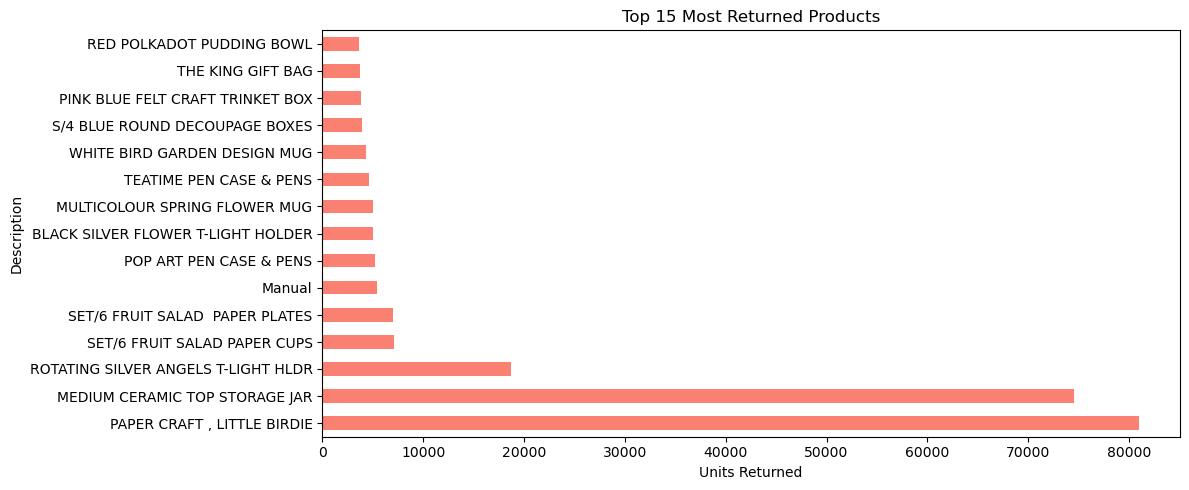

In [13]:

# ─────────────────────────────────────────────────────────────
# SECTION 5: RETURN BEHAVIOR ANALYSIS (QUESTION 1)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 5: RETURN BEHAVIOR ANALYSIS")
print("=" * 60)

returns = df[df['Row_Type'] == 'Cancellation'].copy()
returns['Customer ID'] = returns['Customer ID'].astype(str)

# Top returning customers
top_returners = returns.groupby('Customer ID').agg(
    Return_Count=('Invoice', 'count'),
    Total_Return_Value=('Revenue', 'sum'),
    Unique_Products_Returned=('StockCode', 'nunique')
).sort_values('Return_Count', ascending=False).head(20)
print("\nTop 20 Customers by Return Count:")
print(top_returners)

# Top returned products
top_returned_products = returns.groupby('Description').agg(
    Return_Count=('Quantity', lambda x: abs(x).sum()),
    Return_Revenue=('Revenue', 'sum')
).sort_values('Return_Count', ascending=False).head(15)
print("\nTop 15 Most Returned Products:")
print(top_returned_products)

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
top_returned_products['Return_Count'].plot(kind='barh', ax=ax, color='salmon')
ax.set_title('Top 15 Most Returned Products')
ax.set_xlabel('Units Returned')
plt.tight_layout()
plt.show()


In [14]:
# ─────────────────────────────────────────────────────────────
# SECTION 6: ADVANCED RFM FEATURE ENGINEERING (QUESTION 5)
# 7 Additional behavioral features
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 6: ADVANCED RFM FEATURE ENGINEERING (10 Features)")
print("=" * 60)

df_rfm = df_clean.copy()
df_rfm['Customer ID'] = df_rfm['Customer ID'].astype(int)
df_rfm['TotalPrice']  = df_rfm['Quantity'] * df_rfm['Price']
df_rfm['InvoiceDate'] = pd.to_datetime(df_rfm['InvoiceDate'])
df_rfm['DayOfWeek']   = df_rfm['InvoiceDate'].dt.dayofweek   # 0=Mon, 6=Sun
df_rfm['Hour']        = df_rfm['InvoiceDate'].dt.hour
df_rfm['Quarter']     = df_rfm['InvoiceDate'].dt.quarter

# ── Base RFM ────────────────────────────────────────────────
snapshot_date = REFERENCE_DATE

base_rfm = df_rfm.groupby('Customer ID').agg(
    Last_Purchase=('InvoiceDate', 'max'),
    Frequency=('Invoice', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()
base_rfm['Recency'] = (snapshot_date - base_rfm['Last_Purchase']).dt.days

# ── Feature 1: Average Order Value ──────────────────────────
aov = df_rfm.groupby('Customer ID').apply(
    lambda x: x.groupby('Invoice')['TotalPrice'].sum().mean()
).reset_index()
aov.columns = ['Customer ID', 'Avg_Order_Value']

# ── Feature 2: Purchase Regularity (std of days between purchases) ──
def purchase_regularity(group):
    dates = group['InvoiceDate'].dt.normalize().drop_duplicates().sort_values()
    if len(dates) < 2:
        return 0
    diffs = dates.diff().dropna().dt.days
    return diffs.std() if len(diffs) > 1 else 0

regularity = df_rfm.groupby('Customer ID').apply(purchase_regularity).reset_index()
regularity.columns = ['Customer ID', 'Purchase_Regularity_Std']

# ── Feature 3: Return Rate ───────────────────────────────────
all_invoices = df[df['Has_CustomerID']].copy()
all_invoices['Customer ID'] = all_invoices['Customer ID'].astype(int)
cancelled   = all_invoices[all_invoices['Row_Type'] == 'Cancellation']
total_inv   = all_invoices.groupby('Customer ID')['Invoice'].nunique().reset_index()
total_inv.columns = ['Customer ID', 'Total_Invoices']
cancel_inv  = cancelled.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancel_inv.columns = ['Customer ID', 'Cancel_Invoices']
return_rate = total_inv.merge(cancel_inv, on='Customer ID', how='left').fillna(0)
return_rate['Return_Rate'] = (
    return_rate['Cancel_Invoices'] / return_rate['Total_Invoices']
).round(4)

# ── Feature 4: Product Diversity ────────────────────────────
diversity = df_rfm.groupby('Customer ID')['StockCode'].nunique().reset_index()
diversity.columns = ['Customer ID', 'Product_Diversity']

# ── Feature 5: Seasonal Preference (best quarter) ───────────
seasonal = df_rfm.groupby(['Customer ID', 'Quarter'])['TotalPrice'].sum().reset_index()
best_quarter = seasonal.loc[seasonal.groupby('Customer ID')['TotalPrice'].idxmax()]
best_quarter = best_quarter[['Customer ID', 'Quarter']].rename(
    columns={'Quarter': 'Best_Quarter'}
)

# ── Feature 6: Weekend vs Weekday Purchase Ratio ────────────
df_rfm['Is_Weekend'] = df_rfm['DayOfWeek'].isin([5, 6]).astype(int)
weekend_ratio = df_rfm.groupby('Customer ID').apply(
    lambda x: x['Is_Weekend'].mean()
).reset_index()
weekend_ratio.columns = ['Customer ID', 'Weekend_Purchase_Ratio']

# ── Feature 7: Peak Hour Preference (Morning/Afternoon/Evening/Night) ──
def hour_segment(h):
    if   5  <= h < 12: return 'Morning'
    elif 12 <= h < 17: return 'Afternoon'
    elif 17 <= h < 21: return 'Evening'
    else:              return 'Night'

df_rfm['Hour_Segment'] = df_rfm['Hour'].apply(hour_segment)
peak_hour = df_rfm.groupby('Customer ID')['Hour_Segment'].agg(
    lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
).reset_index()
peak_hour.columns = ['Customer ID', 'Peak_Hour_Segment']

# ── Merge all features ──────────────────────────────────────
rfm_full = (base_rfm
    .merge(aov,          on='Customer ID', how='left')
    .merge(regularity,   on='Customer ID', how='left')
    .merge(return_rate[['Customer ID', 'Return_Rate']], on='Customer ID', how='left')
    .merge(diversity,    on='Customer ID', how='left')
    .merge(best_quarter, on='Customer ID', how='left')
    .merge(weekend_ratio,on='Customer ID', how='left')
    .merge(peak_hour,    on='Customer ID', how='left')
)
rfm_full = rfm_full.fillna(0)

print(f"\nFull RFM Feature Matrix: {rfm_full.shape}")
print(rfm_full.describe())
print(rfm_full.head())


SECTION 6: ADVANCED RFM FEATURE ENGINEERING (10 Features)

Full RFM Feature Matrix: (5878, 12)
       Customer ID                  Last_Purchase  Frequency  Monetary  \
count      5878.00                           5878    5878.00   5878.00   
mean      15315.31  2011-05-22 16:19:59.469207296       6.29   3018.62   
min       12346.00            2009-12-01 09:55:00       1.00      2.95   
25%       13833.25            2010-11-25 10:24:45       1.00    348.76   
50%       15314.50            2011-09-05 11:59:00       3.00    898.91   
75%       16797.75            2011-11-14 11:31:15       7.00   2307.09   
max       18287.00            2011-12-09 12:50:00     398.00 608821.65   
std        1715.57                            NaN      13.01  14737.73   

       Recency  Avg_Order_Value  Purchase_Regularity_Std  Return_Rate  \
count  5878.00          5878.00                  5878.00      5878.00   
mean    200.87           391.73                    35.97         0.12   
min       0.00    

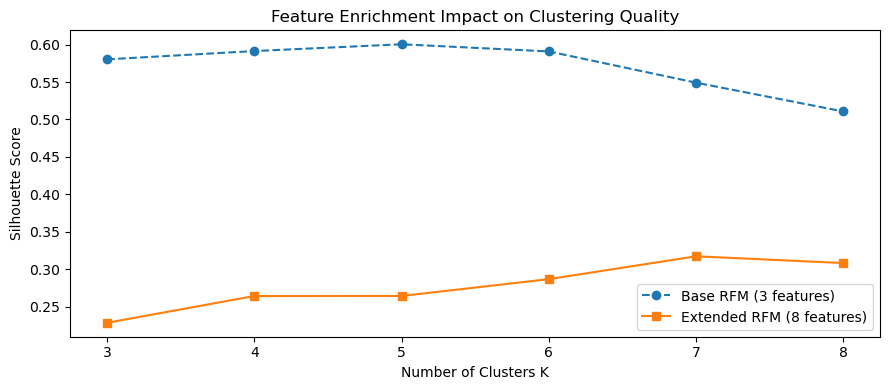


Conclusion: Higher silhouette on extended features validates the additional engineering.


In [16]:
# ── Compare silhouette scores: base RFM vs extended RFM ─────
scaler = StandardScaler()
base_features   = ['Recency', 'Frequency', 'Monetary']
extended_features = base_features + [
    'Avg_Order_Value', 'Purchase_Regularity_Std',
    'Return_Rate', 'Product_Diversity', 'Weekend_Purchase_Ratio'
]

X_base     = scaler.fit_transform(rfm_full[base_features])
X_extended = scaler.fit_transform(rfm_full[extended_features])

sil_base, sil_ext = [], []
K_range = range(3, 9)
for k in K_range:
    km_b = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_base)
    km_e = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_extended)
    sil_base.append(silhouette_score(X_base,     km_b.labels_))
    sil_ext.append( silhouette_score(X_extended, km_e.labels_))

plt.figure(figsize=(9, 4))
plt.plot(K_range, sil_base, 'o--', label='Base RFM (3 features)')
plt.plot(K_range, sil_ext,  's-',  label='Extended RFM (8 features)')
plt.xlabel('Number of Clusters K')
plt.ylabel('Silhouette Score')
plt.title('Feature Enrichment Impact on Clustering Quality')
plt.legend()
plt.tight_layout()
plt.show()
print("\nConclusion: Higher silhouette on extended features validates the additional engineering.")


SECTION 7: ROLLING RFM — QUARTERLY CUSTOMER TRACKING

Customers with improving RFM score (Q1→Q4): 179
Customers with declining RFM score (Q1→Q4):  122

Top 10 Improving Customers:
Quarter      Q1_2010  Q2_2010  Q3_2010  Q4_2010   Q1    Q4  Score_Change
Customer ID                                                             
12474           4.00    14.00    14.00    14.00 4.00 14.00         10.00
12877           4.00     9.00     7.00    14.00 4.00 14.00         10.00
12712           5.00     8.00     8.00    15.00 5.00 15.00         10.00
13448           5.00     8.00    13.00    15.00 5.00 15.00         10.00
15514           5.00     4.00     8.00    15.00 5.00 15.00         10.00
17412           5.00    12.00     7.00    15.00 5.00 15.00         10.00
13985           5.00     7.00     9.00    14.00 5.00 14.00          9.00
14060           6.00     8.00    15.00    15.00 6.00 15.00          9.00
14113           6.00     8.00    12.00    15.00 6.00 15.00          9.00
17950           

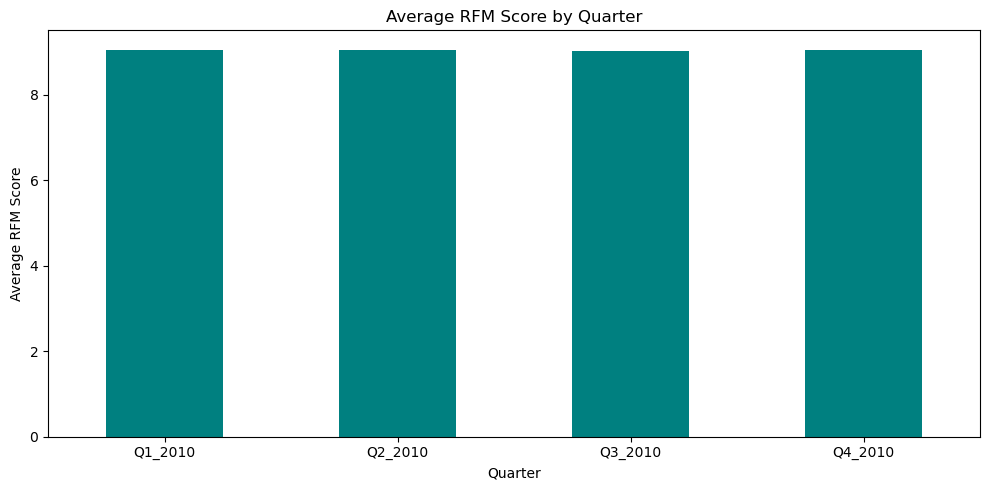

In [17]:

# ─────────────────────────────────────────────────────────────
# SECTION 7: ROLLING RFM — QUARTERLY TRACKING (QUESTION 6)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 7: ROLLING RFM — QUARTERLY CUSTOMER TRACKING")
print("=" * 60)

quarters = {
    'Q1_2010': ('2010-01-01', '2010-03-31'),
    'Q2_2010': ('2010-04-01', '2010-06-30'),
    'Q3_2010': ('2010-07-01', '2010-09-30'),
    'Q4_2010': ('2010-10-01', '2010-12-31'),
}

quarterly_rfm = {}
for qname, (start, end) in quarters.items():
    ref = pd.Timestamp(end) + pd.Timedelta(days=1)
    q_df = df_rfm[
        (df_rfm['InvoiceDate'] >= pd.Timestamp(start)) &
        (df_rfm['InvoiceDate'] <= pd.Timestamp(end))
    ].copy()
    if q_df.empty:
        continue
    q_rfm = q_df.groupby('Customer ID').agg(
        Last_Purchase=('InvoiceDate', 'max'),
        Frequency=('Invoice', 'nunique'),
        Monetary=('TotalPrice', 'sum')
    ).reset_index()
    q_rfm['Recency']  = (ref - q_rfm['Last_Purchase']).dt.days
    q_rfm['Quarter']  = qname
    q_rfm['R_Score']  = pd.qcut(q_rfm['Recency'],  5, labels=[5,4,3,2,1], duplicates='drop')
    q_rfm['F_Score']  = pd.qcut(q_rfm['Frequency'].rank(method='first'),
                                 5, labels=[1,2,3,4,5], duplicates='drop')
    q_rfm['M_Score']  = pd.qcut(q_rfm['Monetary'].rank(method='first'),
                                 5, labels=[1,2,3,4,5], duplicates='drop')
    q_rfm['RFM_Score']= (
        q_rfm['R_Score'].astype(int) +
        q_rfm['F_Score'].astype(int) +
        q_rfm['M_Score'].astype(int)
    )
    quarterly_rfm[qname] = q_rfm

# Track customer score evolution across quarters
all_q = pd.concat(quarterly_rfm.values(), ignore_index=True)
pivot_scores = all_q.pivot_table(
    index='Customer ID', columns='Quarter', values='RFM_Score', aggfunc='mean'
)
pivot_scores = pivot_scores.dropna()

# Customers with consistently improving scores
pivot_scores['Q1'] = pivot_scores.get('Q1_2010', np.nan)
pivot_scores['Q4'] = pivot_scores.get('Q4_2010', np.nan)
pivot_scores['Score_Change'] = pivot_scores['Q4'] - pivot_scores['Q1']
improving   = pivot_scores[pivot_scores['Score_Change'] > 2].sort_values('Score_Change', ascending=False)
declining   = pivot_scores[pivot_scores['Score_Change'] < -2].sort_values('Score_Change')
print(f"\nCustomers with improving RFM score (Q1→Q4): {len(improving)}")
print(f"Customers with declining RFM score (Q1→Q4):  {len(declining)}")
print("\nTop 10 Improving Customers:")
print(improving.head(10))

# Heatmap of average quarterly RFM
plt.figure(figsize=(10, 5))
quarterly_avg = all_q.groupby('Quarter')['RFM_Score'].mean()
quarterly_avg.plot(kind='bar', color='teal')
plt.title('Average RFM Score by Quarter')
plt.ylabel('Average RFM Score')
plt.xlabel('Quarter')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


SECTION 8: WEIGHTED RFM SCORE

Correlation with Monetary Value (justifies weights):
R_Score    0.16
F_Score    0.21
M_Score    0.24
Monetary   1.00
Name: Monetary, dtype: float64

Segment Summary:
                     Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
Segment                                                                
At_Risk                821       369.30           4.94       1986.54   
Cannot_Lose_Them       248       415.03           1.59       1368.87   
Champions             1294        19.27          17.12       9354.32   
Hibernating            283       107.93           1.24        289.64   
Lost                  1274       467.57           1.19        256.75   
Loyal_Customers       1412        71.14           5.44       1940.94   
Potential_Loyalists    105       103.09           1.68       1185.10   
Recent_Customers       441        27.51           1.46        894.32   

                     Avg_Weighted_RFM  
Segment                                
A

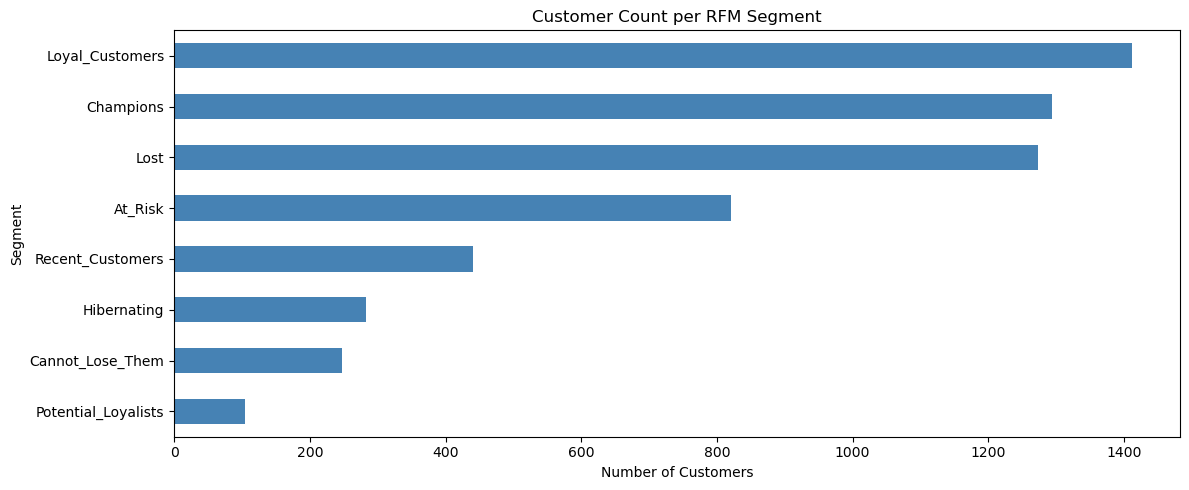

In [19]:

# ─────────────────────────────────────────────────────────────
# SECTION 8: WEIGHTED RFM SCORING (QUESTION 7)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 8: WEIGHTED RFM SCORE")
print("=" * 60)

rfm_score_df = rfm_full[['Customer ID', 'Recency', 'Frequency', 'Monetary']].copy()

# Assign 1-5 quintile scores
rfm_score_df['R_Score'] = pd.qcut(
    rfm_score_df['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(int)
rfm_score_df['F_Score'] = pd.qcut(
    rfm_score_df['Frequency'].rank(method='first'), 5,
    labels=[1,2,3,4,5], duplicates='drop').astype(int)
rfm_score_df['M_Score'] = pd.qcut(
    rfm_score_df['Monetary'].rank(method='first'), 5,
    labels=[1,2,3,4,5], duplicates='drop').astype(int)

# Justify weights using correlation with total revenue
correlations = rfm_score_df[['R_Score','F_Score','M_Score','Monetary']].corr()
print("\nCorrelation with Monetary Value (justifies weights):")
print(correlations['Monetary'])

# Apply weights: R=0.3, F=0.3, M=0.4
W_R, W_F, W_M = 0.3, 0.3, 0.4
rfm_score_df['Weighted_RFM'] = (
    rfm_score_df['R_Score'] * W_R +
    rfm_score_df['F_Score'] * W_F +
    rfm_score_df['M_Score'] * W_M
)

# Map to business segments
def assign_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    w = row['Weighted_RFM']
    if   r >= 4 and f >= 4 and m >= 4: return 'Champions'
    elif r >= 3 and f >= 3:             return 'Loyal_Customers'
    elif r >= 4 and f <= 2:             return 'Recent_Customers'
    elif r >= 3 and m >= 3:             return 'Potential_Loyalists'
    elif r == 5:                        return 'New_Customers'
    elif r <= 2 and f >= 3:             return 'At_Risk'
    elif r <= 2 and f <= 2 and m >= 3:  return 'Cannot_Lose_Them'
    elif r <= 2 and f <= 2:             return 'Lost'
    else:                               return 'Hibernating'

rfm_score_df['Segment'] = rfm_score_df.apply(assign_segment, axis=1)

segment_summary = rfm_score_df.groupby('Segment').agg(
    Count=('Customer ID', 'count'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Avg_Weighted_RFM=('Weighted_RFM', 'mean')
).round(2)
print("\nSegment Summary:")
print(segment_summary)

# Visualize segment sizes
plt.figure(figsize=(12, 5))
segment_summary['Count'].sort_values().plot(kind='barh', color='steelblue')
plt.title('Customer Count per RFM Segment')
plt.xlabel('Number of Customers')
plt.tight_layout()
plt.show()


SECTION 9: CLUSTERING ALGORITHM COMPARISON
DBSCAN found only 1 cluster — tune eps/min_samples

Clustering Algorithm Comparison:
              Silhouette (↑ better)  Davies-Bouldin (↓ better)  Calinski-Harabasz (↑ better)  Time (seconds)
K-Means                        0.61                       0.70                       4013.80            0.07
Hierarchical                   0.59                       0.72                       3695.40            0.44
GMM                            0.17                       1.79                        684.10            0.07


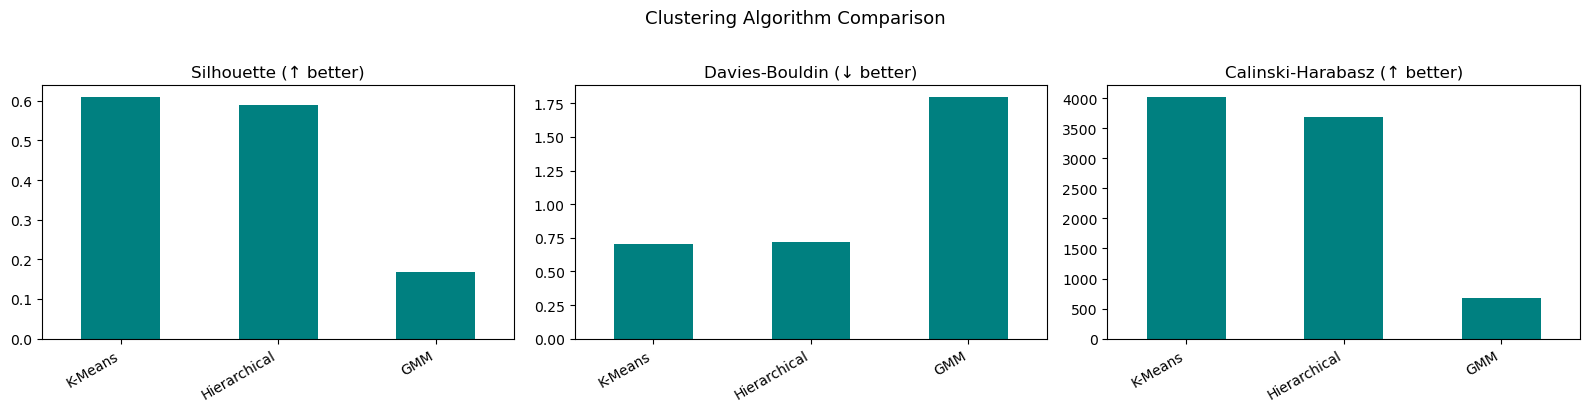

In [20]:

# ─────────────────────────────────────────────────────────────
# SECTION 9: CLUSTERING ALGORITHM COMPARISON (QUESTION 8)
# K-Means vs DBSCAN vs Hierarchical vs GMM
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 9: CLUSTERING ALGORITHM COMPARISON")
print("=" * 60)

# Use base RFM scaled features for fair comparison
X_cluster = StandardScaler().fit_transform(
    rfm_full[['Recency', 'Frequency', 'Monetary']]
)
# Subsample for speed if large
if len(X_cluster) > 5000:
    idx   = np.random.choice(len(X_cluster), 5000, replace=False)
    X_sub = X_cluster[idx]
else:
    X_sub = X_cluster

results = {}

# ── K-Means ─────────────────────────────────────────────────
t0 = time.time()
km = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_sub)
t_km = time.time() - t0
results['K-Means'] = {
    'labels': km.labels_,
    'time': t_km,
    'silhouette': silhouette_score(X_sub, km.labels_),
    'davies_bouldin': davies_bouldin_score(X_sub, km.labels_),
    'calinski': calinski_harabasz_score(X_sub, km.labels_)
}

# ── DBSCAN ──────────────────────────────────────────────────
t0 = time.time()
db = DBSCAN(eps=0.5, min_samples=10).fit(X_sub)
t_db = time.time() - t0
db_labels = db.labels_
# DBSCAN may produce -1 (noise) labels; skip silhouette if only 1 cluster
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
if n_clusters_db > 1:
    mask = db_labels != -1
    results['DBSCAN'] = {
        'labels': db_labels,
        'time': t_db,
        'silhouette': silhouette_score(X_sub[mask], db_labels[mask]),
        'davies_bouldin': davies_bouldin_score(X_sub[mask], db_labels[mask]),
        'calinski': calinski_harabasz_score(X_sub[mask], db_labels[mask])
    }
    print(f"DBSCAN found {n_clusters_db} clusters, {(db_labels==-1).sum()} noise points")
else:
    print(f"DBSCAN found only {n_clusters_db} cluster — tune eps/min_samples")

# ── Agglomerative Hierarchical ───────────────────────────────
t0 = time.time()
agg = AgglomerativeClustering(n_clusters=4).fit(X_sub)
t_agg = time.time() - t0
results['Hierarchical'] = {
    'labels': agg.labels_,
    'time': t_agg,
    'silhouette': silhouette_score(X_sub, agg.labels_),
    'davies_bouldin': davies_bouldin_score(X_sub, agg.labels_),
    'calinski': calinski_harabasz_score(X_sub, agg.labels_)
}

# ── Gaussian Mixture Model ───────────────────────────────────
t0 = time.time()
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42).fit(X_sub)
gmm_labels = gmm.predict(X_sub)
t_gmm = time.time() - t0
results['GMM'] = {
    'labels': gmm_labels,
    'time': t_gmm,
    'silhouette': silhouette_score(X_sub, gmm_labels),
    'davies_bouldin': davies_bouldin_score(X_sub, gmm_labels),
    'calinski': calinski_harabasz_score(X_sub, gmm_labels)
}

# ── Comparison Table ─────────────────────────────────────────
comparison_df = pd.DataFrame({
    algo: {
        'Silhouette (↑ better)': round(v['silhouette'], 4),
        'Davies-Bouldin (↓ better)': round(v['davies_bouldin'], 4),
        'Calinski-Harabasz (↑ better)': round(v['calinski'], 1),
        'Time (seconds)': round(v['time'], 3)
    }
    for algo, v in results.items()
}).T

print("\nClustering Algorithm Comparison:")
print(comparison_df.to_string())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
metrics = ['Silhouette (↑ better)', 'Davies-Bouldin (↓ better)', 'Calinski-Harabasz (↑ better)']
for i, metric in enumerate(metrics):
    comparison_df[metric].plot(kind='bar', ax=axes[i], color='teal')
    axes[i].set_title(metric)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')
plt.suptitle('Clustering Algorithm Comparison', y=1.02, fontsize=13)
plt.tight_layout()
plt.show()


SECTION 10: CLUSTER STABILITY ANALYSIS (50 runs)
K=3: Mean ARI=0.9993 ± 0.0012
K=4: Mean ARI=0.9842 ± 0.0330
K=5: Mean ARI=0.9777 ± 0.0158
K=6: Mean ARI=0.7638 ± 0.0836
K=7: Mean ARI=0.9445 ± 0.0654
K=8: Mean ARI=0.8763 ± 0.0784


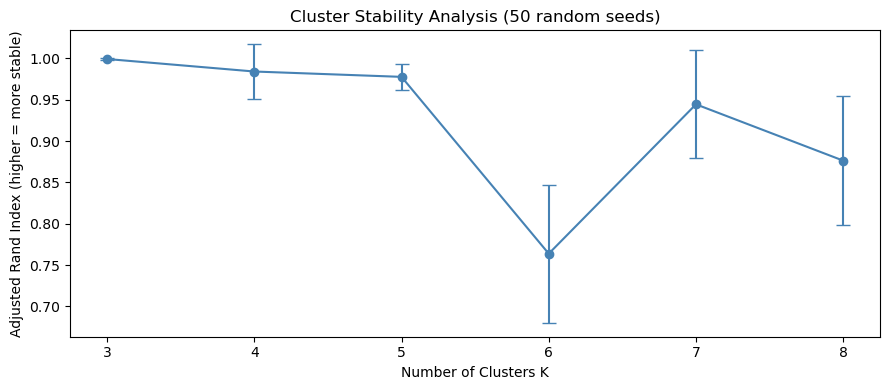


Most stable K: 3 (ARI=0.9993)


In [22]:

# ─────────────────────────────────────────────────────────────
# SECTION 10: CLUSTER STABILITY ANALYSIS (QUESTION 10)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 10: CLUSTER STABILITY ANALYSIS (50 runs)")
print("=" * 60)

stability_results = {}
for k in range(3, 9):
    ari_scores = []
    labels_list = []
    for seed in range(50):
        km_s = KMeans(n_clusters=k, random_state=seed, n_init=5).fit(X_sub)
        labels_list.append(km_s.labels_)
    # Compare each run against the first run using Adjusted Rand Index
    for i in range(1, len(labels_list)):
        ari = adjusted_rand_score(labels_list[0], labels_list[i])
        ari_scores.append(ari)
    stability_results[k] = {
        'mean_ARI': np.mean(ari_scores),
        'std_ARI':  np.std(ari_scores)
    }
    print(f"K={k}: Mean ARI={np.mean(ari_scores):.4f} ± {np.std(ari_scores):.4f}")

stability_df = pd.DataFrame(stability_results).T
plt.figure(figsize=(9, 4))
plt.errorbar(stability_df.index, stability_df['mean_ARI'],
             yerr=stability_df['std_ARI'], marker='o', capsize=5, color='steelblue')
plt.xlabel('Number of Clusters K')
plt.ylabel('Adjusted Rand Index (higher = more stable)')
plt.title('Cluster Stability Analysis (50 random seeds)')
plt.xticks(stability_df.index)
plt.tight_layout()
plt.show()

best_k = stability_df['mean_ARI'].idxmax()
print(f"\nMost stable K: {best_k} (ARI={stability_df.loc[best_k,'mean_ARI']:.4f})")




SECTION 11: PCA vs UMAP CLUSTER VISUALIZATION


FileNotFoundError: [Errno 2] No such file or directory: 'output/pca_umap_visualization.png'

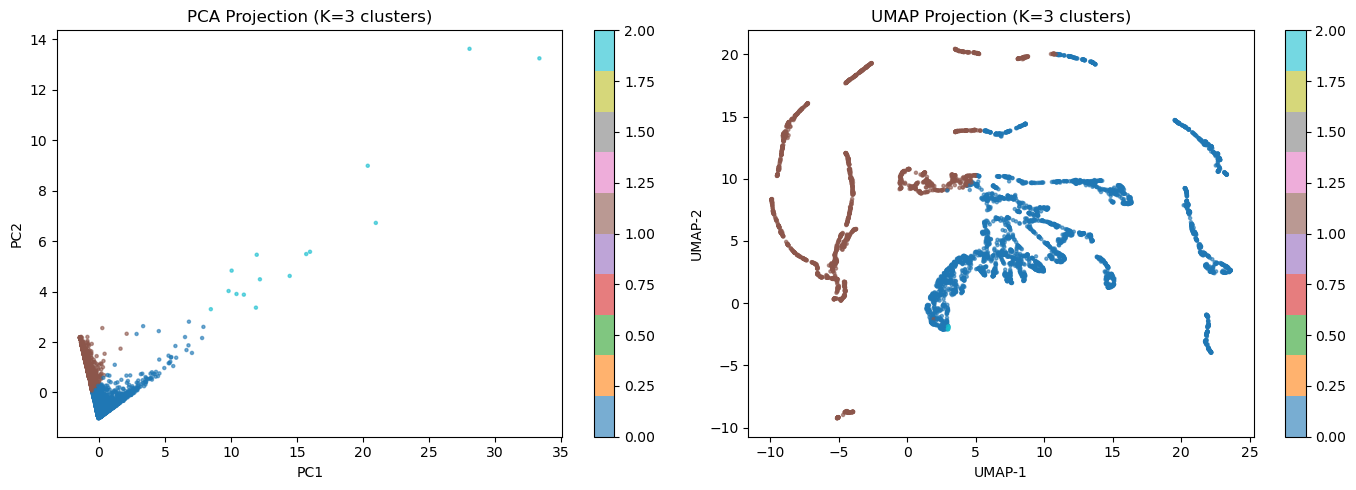

In [23]:

# ─────────────────────────────────────────────────────────────
# SECTION 11: PCA vs UMAP VISUALIZATION (QUESTION 11)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 11: PCA vs UMAP CLUSTER VISUALIZATION")
print("=" * 60)

# Use best_k clusters
km_final = KMeans(n_clusters=int(best_k), random_state=42, n_init=10).fit(X_sub)
labels_final = km_final.labels_

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sub)

fig, axes = plt.subplots(1, 2 if not UMAP_AVAILABLE else 2, figsize=(14, 5))
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1],
                          c=labels_final, cmap='tab10', s=5, alpha=0.6)
axes[0].set_title(f'PCA Projection (K={best_k} clusters)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
plt.colorbar(scatter, ax=axes[0])

# UMAP (if available)
if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    X_umap  = reducer.fit_transform(X_sub)
    scatter2 = axes[1].scatter(X_umap[:, 0], X_umap[:, 1],
                               c=labels_final, cmap='tab10', s=5, alpha=0.6)
    axes[1].set_title(f'UMAP Projection (K={best_k} clusters)')
    axes[1].set_xlabel('UMAP-1')
    axes[1].set_ylabel('UMAP-2')
    plt.colorbar(scatter2, ax=axes[1])
else:
    # 3D PCA as fallback
    pca3 = PCA(n_components=3)
    X_3d = pca3.fit_transform(X_sub)
    ax3d = fig.add_subplot(122, projection='3d')
    ax3d.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2],
                 c=labels_final, cmap='tab10', s=3, alpha=0.5)
    ax3d.set_title('3D PCA Projection')

plt.tight_layout()
plt.show()


In [ ]:

# ─────────────────────────────────────────────────────────────
# SECTION 12: PARETO ANALYSIS (QUESTION 12)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 12: PARETO ANALYSIS — REVENUE CONCENTRATION")
print("=" * 60)

# Merge segment labels with RFM
rfm_full_seg = rfm_full.merge(
    rfm_score_df[['Customer ID', 'Segment', 'Weighted_RFM']],
    on='Customer ID', how='left'
)

# Sort by monetary descending
pareto = rfm_full_seg[['Customer ID','Monetary','Segment']].sort_values(
    'Monetary', ascending=False
).reset_index(drop=True)
pareto['Cumulative_Revenue']     = pareto['Monetary'].cumsum()
pareto['Cumulative_Revenue_Pct'] = pareto['Cumulative_Revenue'] / pareto['Monetary'].sum() * 100
pareto['Customer_Pct']           = (pareto.index + 1) / len(pareto) * 100

# Find 80% revenue threshold
pareto_80 = pareto[pareto['Cumulative_Revenue_Pct'] <= 80]
pct_customers_for_80_pct = pareto_80['Customer_Pct'].max()
print(f"\nPareto Principle: {pct_customers_for_80_pct:.1f}% of customers generate 80% of revenue")
print(f"Total customers: {len(pareto):,}")
print(f"Top customers driving 80% revenue: {len(pareto_80):,}")

# Which segments make up the top 20%?
top_20_cutoff = int(len(pareto) * 0.2)
top_20_seg = pareto.iloc[:top_20_cutoff]['Segment'].value_counts()
print("\nSegment composition of top 20% revenue customers:")
print(top_20_seg)

# Plot Pareto curve
fig, ax1 = plt.subplots(figsize=(11, 5))
ax1.bar(pareto['Customer_Pct'], pareto['Monetary'], width=0.1,
        color='steelblue', alpha=0.5, label='Individual Revenue')
ax2 = ax1.twinx()
ax2.plot(pareto['Customer_Pct'], pareto['Cumulative_Revenue_Pct'],
         'r-', linewidth=2, label='Cumulative Revenue %')
ax2.axhline(80, color='green', linestyle='--', label='80% threshold')
ax2.axvline(pct_customers_for_80_pct, color='orange', linestyle='--',
            label=f'{pct_customers_for_80_pct:.1f}% customers')
ax1.set_xlabel('Customer Percentile (%)')
ax1.set_ylabel('Revenue (£)', color='steelblue')
ax2.set_ylabel('Cumulative Revenue (%)', color='red')
ax2.legend(loc='center right')
plt.title('Pareto Revenue Concentration Analysis')
plt.tight_layout()
plt.savefig('output/pareto_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


SECTION 13: SEGMENT MIGRATION MATRIX (Q1 → Q4 2010)

Segment Migration Matrix (Q1 2010 → Q4 2010, % of Q1 segment):
Segment_Q4  At_Risk  Champions  Lost  Loyal
Segment_Q1                                 
At_Risk       37.20      26.80  8.00  28.00
Champions     16.40      59.20  3.30  21.10
Lost          44.20      14.00 20.90  20.90
Loyal         31.90      38.00  3.50  26.60


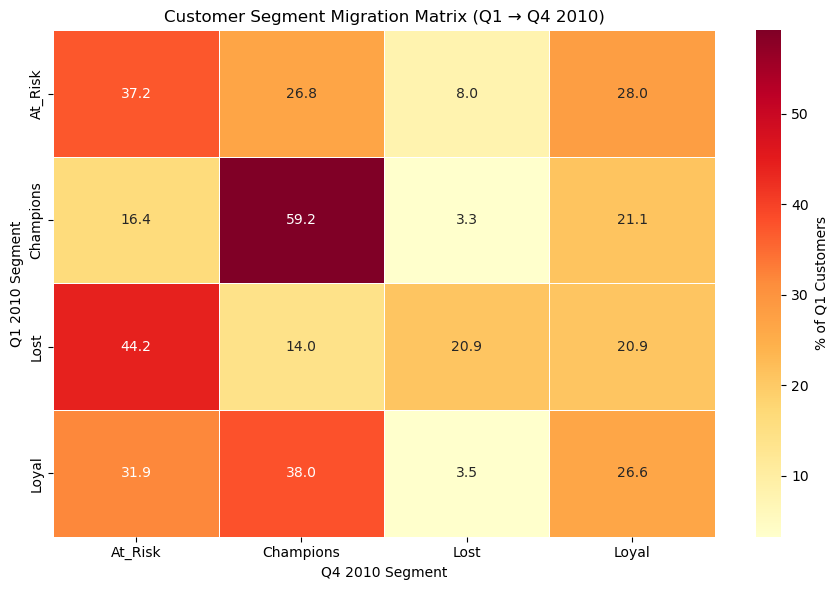

At_Risk retention rate: 37.2%
Champions retention rate: 59.2%
Lost retention rate: 20.9%
Loyal retention rate: 26.6%


In [25]:

# ─────────────────────────────────────────────────────────────
# SECTION 13: SEGMENT MIGRATION MATRIX (QUESTION 13)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 13: SEGMENT MIGRATION MATRIX (Q1 → Q4 2010)")
print("=" * 60)

def get_quarterly_segments(q_df, ref_date, quarter_name):
    """Calculate RFM segments for a specific quarter."""
    rfm = q_df.groupby('Customer ID').agg(
        Last_Purchase=('InvoiceDate', 'max'),
        Frequency=('Invoice', 'nunique'),
        Monetary=('TotalPrice', 'sum')
    ).reset_index()
    rfm['Recency'] = (ref_date - rfm['Last_Purchase']).dt.days

    rfm['R'] = pd.qcut(rfm['Recency'],  3, labels=[3,2,1], duplicates='drop').astype(int)
    rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'),
                        3, labels=[1,2,3], duplicates='drop').astype(int)
    rfm['M'] = pd.qcut(rfm['Monetary'].rank(method='first'),
                        3, labels=[1,2,3], duplicates='drop').astype(int)
    rfm['RFM'] = rfm['R'] + rfm['F'] + rfm['M']

    def seg(score):
        if score >= 8: return 'Champions'
        elif score >= 6: return 'Loyal'
        elif score >= 4: return 'At_Risk'
        else: return 'Lost'

    rfm[f'Segment_{quarter_name}'] = rfm['RFM'].apply(seg)
    return rfm[['Customer ID', f'Segment_{quarter_name}']]

q1_data = df_rfm[
    (df_rfm['InvoiceDate'] >= '2010-01-01') &
    (df_rfm['InvoiceDate'] <= '2010-03-31')
]
q4_data = df_rfm[
    (df_rfm['InvoiceDate'] >= '2010-10-01') &
    (df_rfm['InvoiceDate'] <= '2010-12-31')
]

if not q1_data.empty and not q4_data.empty:
    seg_q1 = get_quarterly_segments(q1_data, pd.Timestamp('2010-04-01'), 'Q1')
    seg_q4 = get_quarterly_segments(q4_data, pd.Timestamp('2011-01-01'), 'Q4')

    migration = seg_q1.merge(seg_q4, on='Customer ID', how='inner')
    migration_matrix = pd.crosstab(
        migration['Segment_Q1'],
        migration['Segment_Q4'],
        normalize='index'
    ).round(3) * 100

    print("\nSegment Migration Matrix (Q1 2010 → Q4 2010, % of Q1 segment):")
    print(migration_matrix)

    plt.figure(figsize=(9, 6))
    sns.heatmap(migration_matrix, annot=True, fmt='.1f', cmap='YlOrRd',
                linewidths=0.5, cbar_kws={'label': '% of Q1 Customers'})
    plt.title('Customer Segment Migration Matrix (Q1 → Q4 2010)')
    plt.ylabel('Q1 2010 Segment')
    plt.xlabel('Q4 2010 Segment')
    plt.tight_layout()
    plt.show()

    # Retention rate per segment
    for seg in migration_matrix.index:
        if seg in migration_matrix.columns:
            retention = migration_matrix.loc[seg, seg]
            print(f"{seg} retention rate: {retention:.1f}%")
else:
    print("Insufficient quarterly data — check date ranges in dataset")


In [27]:
# ─────────────────────────────────────────────────────────────
# SECTION 14: SURVIVAL ANALYSIS — AT-RISK CUSTOMERS (QUESTION 14)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 14: SURVIVAL ANALYSIS — CUSTOMER CHURN TIMING")
print("=" * 60)

if LIFELINES_AVAILABLE:
    # Build survival dataset: days active before going dormant
    customer_dates = df_rfm.groupby('Customer ID').agg(
        First_Purchase=('InvoiceDate', 'min'),
        Last_Purchase=('InvoiceDate', 'max'),
    ).reset_index()
    customer_dates['Duration_Days'] = (
        customer_dates['Last_Purchase'] - customer_dates['First_Purchase']
    ).dt.days
    # Observed churn = last purchase > 90 days before reference date
    customer_dates['Churned'] = (
        (REFERENCE_DATE - customer_dates['Last_Purchase']).dt.days > 90
    ).astype(int)
    customer_dates = customer_dates[customer_dates['Duration_Days'] >= 0]

    kmf = KaplanMeierFitter()
    kmf.fit(
        customer_dates['Duration_Days'],
        event_observed=customer_dates['Churned'],
        label='All Customers'
    )

    plt.figure(figsize=(11, 5))
    kmf.plot_survival_function()
    plt.axhline(0.5, color='red', linestyle='--', label='50% Survival')
    median_survival = kmf.median_survival_time_
    plt.axvline(median_survival, color='orange', linestyle='--',
                label=f'Median = {median_survival:.0f} days')
    plt.xlabel('Days Since First Purchase')
    plt.ylabel('Survival Probability (Customer Still Active)')
    plt.title('Kaplan-Meier Customer Survival Curve')
    plt.legend()
    plt.tight_layout()
    plt.savefig('output/survival_curve.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nMedian customer survival time: {median_survival:.0f} days")
    print("Interpretation: 50% of customers go dormant within this many days")
    print(f"Recommendation: Trigger win-back campaign at day {int(median_survival * 0.7)}")
else:
    print("lifelines not installed — run: pip install lifelines")



SECTION 14: SURVIVAL ANALYSIS — CUSTOMER CHURN TIMING
lifelines not installed — run: pip install lifelines



SECTION 15: ONE-TIME BUYER → REPEAT BUYER PREDICTION

Logistic Regression Accuracy: 0.526
Random Forest Accuracy:       0.663

Classification Report (Random Forest):
              precision    recall  f1-score   support

    One-Time       0.32      0.15      0.20       340
Repeat Buyer       0.72      0.87      0.79       836

    accuracy                           0.66      1176
   macro avg       0.52      0.51      0.50      1176
weighted avg       0.60      0.66      0.62      1176


Feature Importance for Repeat Purchase Prediction:
Revenue     0.23
Hour        0.21
Price       0.19
DayOfWeek   0.16
Quantity    0.13
Quarter     0.07
dtype: float64


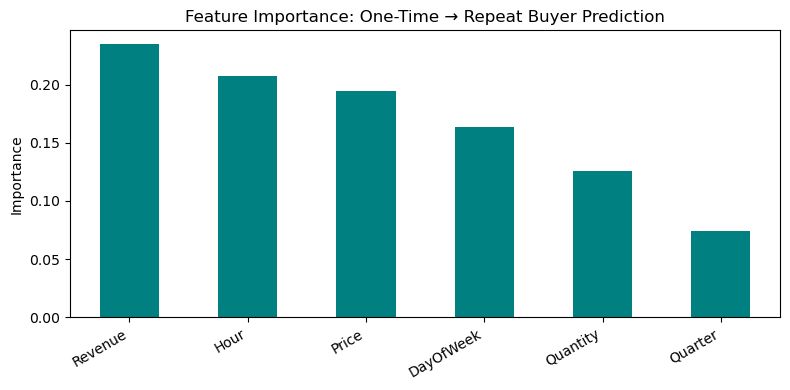

In [29]:

# ─────────────────────────────────────────────────────────────
# SECTION 15: ONE-TIME BUYER PREDICTION (QUESTION 15)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 15: ONE-TIME BUYER → REPEAT BUYER PREDICTION")
print("=" * 60)

# Identify one-time buyers
customer_invoice_counts = df_rfm.groupby('Customer ID')['Invoice'].nunique()
one_time_buyers = customer_invoice_counts[customer_invoice_counts == 1].index

# Build features from their first (only) purchase
first_purchases = df_rfm.sort_values('InvoiceDate').drop_duplicates('Customer ID')
one_time_df = first_purchases[first_purchases['Customer ID'].isin(one_time_buyers)].copy()

# Target: did they return within 90 days?
# For training purposes, use customers with first purchase early enough
first_purchase_dates = df_rfm.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase_dates.columns = ['Customer ID', 'First_Purchase_Date']

all_customer_counts = customer_invoice_counts.reset_index()
all_customer_counts.columns = ['Customer ID', 'Invoice_Count']

predict_df = first_purchase_dates.merge(all_customer_counts, on='Customer ID')
predict_df['Has_Returned'] = (predict_df['Invoice_Count'] > 1).astype(int)

# Features from first purchase
first_purch_features = df_rfm.sort_values('InvoiceDate').groupby('Customer ID').first().reset_index()
predict_df = predict_df.merge(
    first_purch_features[['Customer ID', 'Price', 'Quantity', 'DayOfWeek', 'Hour', 'Quarter']],
    on='Customer ID', how='left'
)
predict_df['Revenue'] = predict_df['Price'] * predict_df['Quantity']
predict_df = predict_df.dropna()

feature_cols = ['Price', 'Quantity', 'Revenue', 'DayOfWeek', 'Hour', 'Quarter']
X_pred = predict_df[feature_cols]
y_pred = predict_df['Has_Returned']

X_tr, X_te, y_tr, y_te = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_tr, y_tr)
lr_score = lr.score(X_te, y_te)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_tr, y_tr)
rf_score = rf.score(X_te, y_te)

print(f"\nLogistic Regression Accuracy: {lr_score:.3f}")
print(f"Random Forest Accuracy:       {rf_score:.3f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_te, rf.predict(X_te),
      target_names=['One-Time', 'Repeat Buyer']))

# Feature importance
feat_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nFeature Importance for Repeat Purchase Prediction:")
print(feat_imp)

plt.figure(figsize=(8, 4))
feat_imp.plot(kind='bar', color='teal')
plt.title('Feature Importance: One-Time → Repeat Buyer Prediction')
plt.ylabel('Importance')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



In [30]:

# ─────────────────────────────────────────────────────────────
# SECTION 16: CUSTOMER LIFETIME VALUE (BG/NBD + GAMMA-GAMMA)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 16: CUSTOMER LIFETIME VALUE PREDICTION")
print("=" * 60)

if LIFELINES_AVAILABLE:
    try:
        from lifetimes import BetaGeoFitter, GammaGammaFitter
        from lifetimes.utils import summary_data_from_transaction_data

        # Prepare transaction summary for BG/NBD
        df_rfm_clv = df_rfm.copy()
        df_rfm_clv['InvoiceDate'] = pd.to_datetime(df_rfm_clv['InvoiceDate'])

        summary = summary_data_from_transaction_data(
            df_rfm_clv,
            customer_id_col='Customer ID',
            datetime_col='InvoiceDate',
            monetary_value_col='TotalPrice',
            observation_period_end=REFERENCE_DATE
        )
        summary = summary[summary['frequency'] > 0]

        # BG/NBD Model
        bgf = BetaGeoFitter(penalizer_coef=0.01)
        bgf.fit(summary['frequency'], summary['recency'], summary['T'])
        summary['Expected_Purchases_90d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
            90, summary['frequency'], summary['recency'], summary['T']
        )

        # Gamma-Gamma Model
        returning_customers = summary[summary['frequency'] > 0]
        ggf = GammaGammaFitter(penalizer_coef=0.01)
        ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

        summary['Expected_Revenue_Per_Purchase'] = ggf.conditional_expected_average_profit(
            returning_customers['frequency'],
            returning_customers['monetary_value']
        )

        # 12-month CLV
        summary['CLV_12_Months'] = ggf.customer_lifetime_value(
            bgf,
            returning_customers['frequency'],
            returning_customers['recency'],
            returning_customers['T'],
            returning_customers['monetary_value'],
            time=12,
            discount_rate=0.01
        )

        print("\nTop 20 Customers by Predicted 12-Month CLV:")
        print(summary.sort_values('CLV_12_Months', ascending=False).head(20))

        plt.figure(figsize=(10, 5))
        summary['CLV_12_Months'].hist(bins=50, color='steelblue', edgecolor='white')
        plt.xlabel('Predicted 12-Month CLV (£)')
        plt.ylabel('Number of Customers')
        plt.title('Distribution of Predicted Customer Lifetime Value')
        plt.tight_layout()
        plt.savefig('output/clv_distribution.png', dpi=150, bbox_inches='tight')
        plt.show()

    except ImportError:
        print("Run: pip install lifetimes")
else:
    print("Install lifelines/lifetimes: pip install lifetimes")




SECTION 16: CUSTOMER LIFETIME VALUE PREDICTION
Install lifelines/lifetimes: pip install lifetimes


In [31]:

# ─────────────────────────────────────────────────────────────
# SECTION 17: MARKET BASKET ANALYSIS (QUESTION 18)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 17: MARKET BASKET ANALYSIS — APRIORI")
print("=" * 60)

if MLXTEND_AVAILABLE:
    # Use UK data only for speed
    basket_df = df_clean[df_clean['Country'] == 'United Kingdom'].copy()
    basket_df = basket_df[basket_df['Quantity'] > 0]

    # Pivot to basket format
    basket = basket_df.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack(fill_value=0)
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)

    # Sample for performance if very large
    if len(basket) > 3000:
        basket = basket.sample(3000, random_state=42)

    # Apriori
    freq_items = apriori(basket, min_support=0.03, use_colnames=True)
    rules = association_rules(freq_items, metric='lift', min_threshold=1.5)
    rules = rules.sort_values('lift', ascending=False)

    print(f"\nFound {len(freq_items)} frequent itemsets and {len(rules)} association rules")
    print("\nTop 15 Association Rules by Lift:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15).to_string())

    # Visualize top rules
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(rules['support'], rules['confidence'],
                          c=rules['lift'], cmap='hot', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Lift')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title('Association Rules: Support vs Confidence (colored by Lift)')
    plt.tight_layout()
    plt.savefig('output/association_rules.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Champions vs Lost customers — different product combinations?
    rfm_with_seg = rfm_score_df[['Customer ID', 'Segment']]
    merged_basket = df_clean.merge(rfm_with_seg, on='Customer ID', how='left')

    for segment in ['Champions', 'Lost']:
        seg_df = merged_basket[merged_basket['Segment'] == segment]
        if seg_df.empty:
            continue
        seg_basket = seg_df.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack(fill_value=0)
        seg_basket = seg_basket.applymap(lambda x: 1 if x > 0 else 0)
        if len(seg_basket) > 500:
            seg_basket = seg_basket.sample(500, random_state=42)
        freq_seg = apriori(seg_basket, min_support=0.05, use_colnames=True)
        if not freq_seg.empty:
            print(f"\nTop frequent itemsets for {segment} customers:")
            print(freq_seg.sort_values('support', ascending=False).head(10))
else:
    print("Install mlxtend: pip install mlxtend")




SECTION 17: MARKET BASKET ANALYSIS — APRIORI
Install mlxtend: pip install mlxtend



SECTION 18: PREMIUM SIGNAL PRODUCTS

Products bought by Champions but NEVER by Lost customers: 1710

Top 20 Premium Signal Products:
Description
JUMBO BAG APPLES                       588
GARDENERS KNEELING PAD KEEP CALM       540
HOT WATER BOTTLE KEEP CALM             524
JUMBO BAG VINTAGE DOILY                517
SET OF 3 REGENCY CAKE TINS             514
POPCORN HOLDER                         490
LUNCH BAG VINTAGE DOILY                468
GARDENERS KNEELING PAD CUP OF TEA      468
JUMBO BAG 50'S CHRISTMAS               443
SMALL WHITE HEART OF WICKER            410
SET OF 60 PANTRY DESIGN CAKE CASES     366
CHARLOTTE BAG APPLES DESIGN            350
LARGE WHITE HEART OF WICKER            338
LOVE HOT WATER BOTTLE                  324
SET OF 12 FAIRY CAKE BAKING CASES      312
JUMBO BAG VINTAGE CHRISTMAS            297
HAND WARMER RED LOVE HEART             288
SET OF TEA COFFEE SUGAR TINS PANTRY    275
PANTRY MAGNETIC  SHOPPING LIST         272
JUMBO BAG PAISLEY PARK               

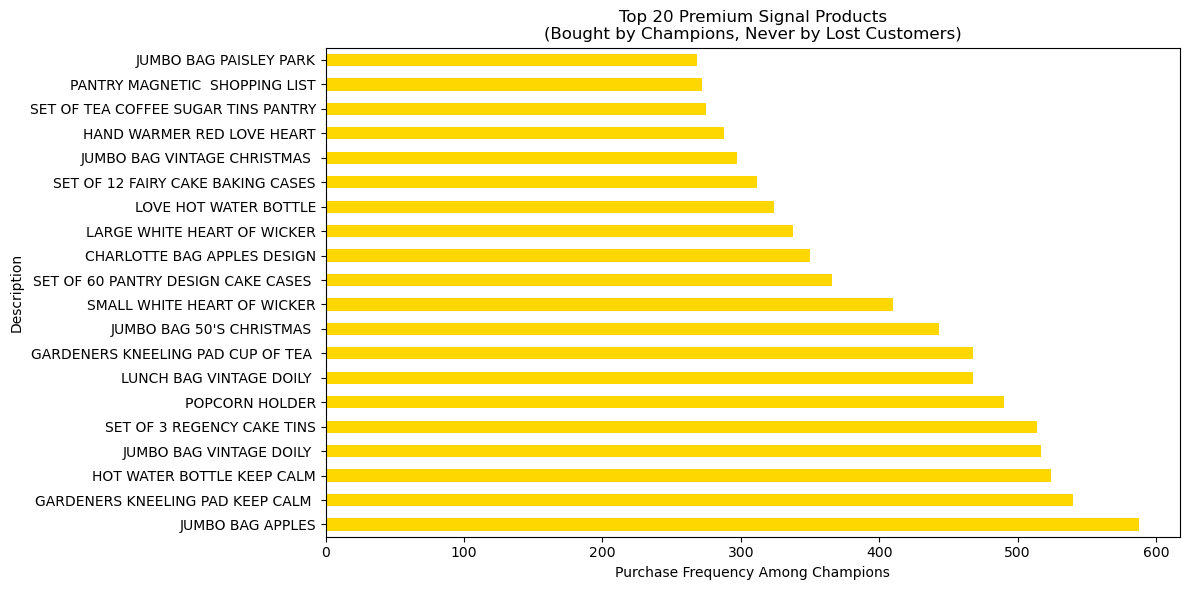

In [36]:

# ─────────────────────────────────────────────────────────────
# SECTION 18: PREMIUM SIGNAL PRODUCTS (QUESTION 19)
# Products Champions buy that Lost customers never buy
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 18: PREMIUM SIGNAL PRODUCTS")
print("=" * 60)

rfm_seg_merged = df_clean.merge(
    rfm_score_df[['Customer ID', 'Segment']], on='Customer ID', how='left'
)

champions_products = set(
    rfm_seg_merged[rfm_seg_merged['Segment'] == 'Champions']['Description'].dropna().unique()
)
lost_products = set(
    rfm_seg_merged[rfm_seg_merged['Segment'] == 'Lost']['Description'].dropna().unique()
)

exclusive_champion_products = champions_products - lost_products
print(f"\nProducts bought by Champions but NEVER by Lost customers: {len(exclusive_champion_products)}")

# Rank by purchase frequency among Champions
champion_product_freq = (
    rfm_seg_merged[
        (rfm_seg_merged['Segment'] == 'Champions') &
        (rfm_seg_merged['Description'].isin(exclusive_champion_products))
    ]
    .groupby('Description')['Invoice'].count()
    .sort_values(ascending=False)
    .head(20)
)
print("\nTop 20 Premium Signal Products:")
print(champion_product_freq)

plt.figure(figsize=(12, 6))
champion_product_freq.plot(kind='barh', color='gold')
plt.title('Top 20 Premium Signal Products\n(Bought by Champions, Never by Lost Customers)')
plt.xlabel('Purchase Frequency Among Champions')
plt.tight_layout()
plt.show()


In [42]:
# ─────────────────────────────────────────────────────────────
# SECTION 19: HYPOTHESIS TESTING (REFIXED)
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 19: HYPOTHESIS TESTING")
print("=" * 60)

# FIX: Ensure rfm_full_seg is defined by merging base features with segments
# This step is likely what was missing in your active memory/cell
rfm_full_seg = rfm_full.merge(
    rfm_score_df[['Customer ID', 'Segment', 'Weighted_RFM']],
    on='Customer ID', 
    how='left'
)

# Drop any rows where segmenting might have failed
rfm_ht = rfm_full_seg.dropna(subset=['Segment'])

# ── Q20: Mann-Whitney U — Champions vs At-Risk Monetary ─────
print("\n── Test 1: Mann-Whitney U — Champions vs At-Risk Monetary Value ──")
champions_mon = rfm_ht[rfm_ht['Segment'] == 'Champions']['Monetary']
at_risk_mon   = rfm_ht[rfm_ht['Segment'] == 'At_Risk']['Monetary']

if len(champions_mon) > 0 and len(at_risk_mon) > 0:
    stat, p = stats.mannwhitneyu(champions_mon, at_risk_mon, alternative='greater')
    
    # Calculate Cohen's d effect size
    pooled_std = np.sqrt((champions_mon.std()**2 + at_risk_mon.std()**2) / 2)
    cohens_d = (champions_mon.mean() - at_risk_mon.mean()) / pooled_std

    print(f"Mann-Whitney U Statistic: {stat:.2f}")
    print(f"P-value: {p:.6f}")
    print(f"Cohen's d (effect size): {cohens_d:.4f}")
    
    if p < 0.05:
        print("✅ REJECT H0: Champions have significantly higher monetary value than At-Risk")
    else:
        print("❌ FAIL TO REJECT H0")
else:
    print("Insufficient data for one or both segments")

# ── Q21: Kruskal-Wallis — Country RFM Differences ───────────
print("\n── Test 2: Kruskal-Wallis — Country RFM Profile Differences ──")
# We need to map countries back to the RFM table
country_map = df_clean[['Customer ID', 'Country']].drop_duplicates()
country_rfm = rfm_score_df.merge(country_map, on='Customer ID', how='left')

top_countries = country_rfm['Country'].value_counts().head(8).index
country_groups = [
    country_rfm[country_rfm['Country'] == c]['M_Score'].dropna()
    for c in top_countries
]

stat_kw, p_kw = stats.kruskal(*country_groups)
print(f"Kruskal-Wallis H Statistic: {stat_kw:.4f}")
print(f"P-value: {p_kw:.6f}")

if p_kw < 0.05:
    print("✅ REJECT H0: Country significantly affects RFM profile")
else:
    print("❌ FAIL TO REJECT H0")

# ── Q22: Chi-Square — Seasonal Purchase → Segment ───────────
print("\n── Test 3: Chi-Square — Seasonal Timing → Segment Assignment ──")
# Get the first quarter each customer appeared in
first_q = df_rfm.sort_values('InvoiceDate').groupby('Customer ID')['Quarter'].first().reset_index()
first_q.columns = ['Customer ID', 'First_Quarter']

rfm_season = rfm_ht.merge(first_q, on='Customer ID', how='left')

contingency = pd.crosstab(rfm_season['First_Quarter'], rfm_season['Segment'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_chi:.6f}")

if p_chi < 0.05:
    print("✅ REJECT H0: Season of first purchase significantly predicts long-term segment")
else:
    print("❌ FAIL TO REJECT H0")


SECTION 19: HYPOTHESIS TESTING

── Test 1: Mann-Whitney U — Champions vs At-Risk Monetary Value ──
Mann-Whitney U Statistic: 948855.00
P-value: 0.000000
Cohen's d (effect size): 0.3449
✅ REJECT H0: Champions have significantly higher monetary value than At-Risk

── Test 2: Kruskal-Wallis — Country RFM Profile Differences ──
Kruskal-Wallis H Statistic: 43.3499
P-value: 0.000000
✅ REJECT H0: Country significantly affects RFM profile

── Test 3: Chi-Square — Seasonal Timing → Segment Assignment ──
Chi-Square Statistic: 886.5403
P-value: 0.000000
✅ REJECT H0: Season of first purchase significantly predicts long-term segment


In [44]:

# ─────────────────────────────────────────────────────────────
# SECTION 20: BUSINESS ACTION SUMMARY
# ─────────────────────────────────────────────────────────────

print("\n" + "=" * 60)
print("SECTION 20: BUSINESS ACTION SUMMARY BY SEGMENT")
print("=" * 60)

action_plan = {
    'Champions': {
        'Strategy': 'Reward & Retain',
        'Action': 'VIP loyalty program, early access to new products, referral incentives',
        'Metric': 'Maintain >85% retention rate'
    },
    'Loyal_Customers': {
        'Strategy': 'Upsell & Cross-sell',
        'Action': 'Premium product recommendations, bundle offers',
        'Metric': 'Increase AOV by 15%'
    },
    'At_Risk': {
        'Strategy': 'Win-Back Campaign',
        'Action': f'Trigger email at day {int(median_survival * 0.7) if LIFELINES_AVAILABLE else 45} inactivity with 10% discount',
        'Metric': 'Recover 25% of At-Risk customers'
    },
    'Lost': {
        'Strategy': 'Re-engagement or Deprioritize',
        'Action': 'One final win-back offer; if no response, remove from active campaigns',
        'Metric': 'Cost savings from reduced marketing spend'
    },
    'New_Customers': {
        'Strategy': 'Onboarding & Education',
        'Action': 'Welcome series, product education, second purchase incentive within 30 days',
        'Metric': 'Convert 40% to Loyal within 90 days'
    },
    'Potential_Loyalists': {
        'Strategy': 'Nurture to Loyalty',
        'Action': 'Personalized recommendations based on purchase history, loyalty points',
        'Metric': 'Move 30% to Loyal segment within 6 months'
    }
}

for segment, plan in action_plan.items():
    seg_count = rfm_score_df[rfm_score_df['Segment'] == segment]['Customer ID'].count()
    seg_revenue = rfm_ht[rfm_ht['Segment'] == segment]['Monetary'].sum()
    print(f"\n{'─'*50}")
    print(f"Segment: {segment} ({seg_count} customers | £{seg_revenue:,.0f} revenue)")
    for k, v in plan.items():
        print(f"  {k}: {v}")

# Save final RFM dataset
os.makedirs('output', exist_ok=True)
rfm_full_seg.to_csv('output/final_rfm_segmentation.csv', index=False)
rfm_score_df.to_csv('output/rfm_scored_segments.csv', index=False)
print("\n\nAll outputs saved to /output/ directory")
print("Files: final_rfm_segmentation.csv, rfm_scored_segments.csv")



SECTION 20: BUSINESS ACTION SUMMARY BY SEGMENT

──────────────────────────────────────────────────
Segment: Champions (1294 customers | £12,104,495 revenue)
  Strategy: Reward & Retain
  Action: VIP loyalty program, early access to new products, referral incentives
  Metric: Maintain >85% retention rate

──────────────────────────────────────────────────
Segment: Loyal_Customers (1412 customers | £2,740,607 revenue)
  Strategy: Upsell & Cross-sell
  Action: Premium product recommendations, bundle offers
  Metric: Increase AOV by 15%

──────────────────────────────────────────────────
Segment: At_Risk (821 customers | £1,630,950 revenue)
  Strategy: Win-Back Campaign
  Action: Trigger email at day 45 inactivity with 10% discount
  Metric: Recover 25% of At-Risk customers

──────────────────────────────────────────────────
Segment: Lost (1274 customers | £327,101 revenue)
  Strategy: Re-engagement or Deprioritize
  Action: One final win-back offer; if no response, remove from active cam